In [17]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np
import pickle

In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
def get_timestep_from_data(json_data, pick_frame_every_no):
    timestep = np.zeros([0, dimensions])
    curr_idx = 0
    
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
            continue
        feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
        timestep = np.vstack((timestep, feature))
        curr_idx += 1
        
    return timestep

    

In [5]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [6]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [7]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [8]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [9]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [10]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_fake_speedup_timesteps_2(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

In [61]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [12]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [13]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [14]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [15]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 5s 7ms/step - loss: 2.9764 - acc: 0.0365 - val_loss: 2.9704 - val_acc: 0.0526
Epoch 2/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9563 - acc: 0.0512 - val_loss: 2.9011 - val_acc: 0.0731
Epoch 3/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9167 - acc: 0.0526 - val_loss: 2.7855 - val_acc: 0.0819
Epoch 4/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.8525 - acc: 0.0804 - val_loss: 2.6644 - val_acc: 0.0965
Epoch 5/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.7583 - acc: 0.0950 - val_loss: 2.6578 - val_acc: 0.1053
Epoch 6/1000
684/684 [==============================] - 3s 5ms/step - loss: 2.6759 - acc: 0.0980 - val_loss: 2.4224 - val_acc: 0.1959
Epoch 7/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.5424 - acc: 0.1404 - val_loss: 2.3662 - val_acc: 0.2076
Epoch 8/1000
684

684/684 [==============================] - 3s 4ms/step - loss: 1.8497 - acc: 0.2602 - val_loss: 1.6252 - val_acc: 0.2982
Epoch 62/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.9003 - acc: 0.2544 - val_loss: 1.6480 - val_acc: 0.2895
Epoch 63/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.8659 - acc: 0.2588 - val_loss: 1.6417 - val_acc: 0.3216
Epoch 64/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.8747 - acc: 0.2705 - val_loss: 1.6531 - val_acc: 0.3450
Epoch 65/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.9002 - acc: 0.2617 - val_loss: 1.6209 - val_acc: 0.3596
Epoch 66/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.8612 - acc: 0.2588 - val_loss: 1.5989 - val_acc: 0.3275
Epoch 67/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.9332 - acc: 0.2632 - val_loss: 1.5969 - val_acc: 0.3421
Epoch 68/1000
684/684 [==============================] - 3s 4ms/step 

684/684 [==============================] - 3s 4ms/step - loss: 1.5695 - acc: 0.4020 - val_loss: 1.3088 - val_acc: 0.4766
Epoch 122/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5974 - acc: 0.4094 - val_loss: 1.2911 - val_acc: 0.4912
Epoch 123/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.5935 - acc: 0.4020 - val_loss: 1.2726 - val_acc: 0.4883
Epoch 124/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.5488 - acc: 0.3904 - val_loss: 1.2857 - val_acc: 0.4942
Epoch 125/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6095 - acc: 0.3743 - val_loss: 1.2558 - val_acc: 0.5205
Epoch 126/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5847 - acc: 0.3977 - val_loss: 1.2641 - val_acc: 0.5205
Epoch 127/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5209 - acc: 0.3904 - val_loss: 1.2687 - val_acc: 0.4883
Epoch 128/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.3648 - acc: 0.4737 - val_loss: 1.0585 - val_acc: 0.6199
Epoch 182/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.3650 - acc: 0.4561 - val_loss: 1.0848 - val_acc: 0.6140
Epoch 183/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.3317 - acc: 0.4825 - val_loss: 1.0592 - val_acc: 0.6170
Epoch 184/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.4138 - acc: 0.4605 - val_loss: 1.0634 - val_acc: 0.6170
Epoch 185/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.3446 - acc: 0.4722 - val_loss: 1.0669 - val_acc: 0.5994
Epoch 186/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.3841 - acc: 0.4810 - val_loss: 1.0549 - val_acc: 0.6316
Epoch 187/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.3450 - acc: 0.4722 - val_loss: 1.0545 - val_acc: 0.6433
Epoch 188/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.2752 - acc: 0.5146 - val_loss: 0.9439 - val_acc: 0.6696
Epoch 242/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1664 - acc: 0.5658 - val_loss: 0.9194 - val_acc: 0.6725
Epoch 243/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2576 - acc: 0.5365 - val_loss: 0.9205 - val_acc: 0.6842
Epoch 244/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2231 - acc: 0.5351 - val_loss: 0.8972 - val_acc: 0.7018
Epoch 245/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2092 - acc: 0.5439 - val_loss: 0.8797 - val_acc: 0.6988
Epoch 246/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1680 - acc: 0.5541 - val_loss: 0.8856 - val_acc: 0.6754
Epoch 247/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.2202 - acc: 0.5556 - val_loss: 0.9019 - val_acc: 0.6813
Epoch 248/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.1836 - acc: 0.5877 - val_loss: 0.7863 - val_acc: 0.7485
Epoch 302/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0938 - acc: 0.5906 - val_loss: 0.7881 - val_acc: 0.7456
Epoch 303/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0649 - acc: 0.6140 - val_loss: 0.7868 - val_acc: 0.7427
Epoch 304/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.1537 - acc: 0.5746 - val_loss: 0.7888 - val_acc: 0.7368
Epoch 305/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.1419 - acc: 0.5921 - val_loss: 0.7916 - val_acc: 0.7573
Epoch 306/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1176 - acc: 0.6199 - val_loss: 0.7740 - val_acc: 0.7602
Epoch 307/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1510 - acc: 0.5936 - val_loss: 0.7901 - val_acc: 0.7398
Epoch 308/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 1.0543 - acc: 0.6082 - val_loss: 0.7180 - val_acc: 0.7515
Epoch 362/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0719 - acc: 0.6067 - val_loss: 0.6971 - val_acc: 0.7515
Epoch 363/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0964 - acc: 0.6053 - val_loss: 0.6994 - val_acc: 0.7544
Epoch 364/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.1486 - acc: 0.6023 - val_loss: 0.7267 - val_acc: 0.7485
Epoch 365/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0402 - acc: 0.6184 - val_loss: 0.7038 - val_acc: 0.7719
Epoch 366/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0320 - acc: 0.6447 - val_loss: 0.6906 - val_acc: 0.7661
Epoch 367/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.0521 - acc: 0.6126 - val_loss: 0.6911 - val_acc: 0.7632
Epoch 368/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 5ms/step - loss: 0.9708 - acc: 0.6784 - val_loss: 0.6543 - val_acc: 0.7690
Epoch 422/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9806 - acc: 0.6740 - val_loss: 0.6489 - val_acc: 0.7836
Epoch 423/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0759 - acc: 0.6418 - val_loss: 0.6452 - val_acc: 0.7719
Epoch 424/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.0147 - acc: 0.6418 - val_loss: 0.6448 - val_acc: 0.7661
Epoch 425/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9854 - acc: 0.6462 - val_loss: 0.6576 - val_acc: 0.7749
Epoch 426/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9442 - acc: 0.6564 - val_loss: 0.6471 - val_acc: 0.7895
Epoch 427/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.0415 - acc: 0.6491 - val_loss: 0.6315 - val_acc: 0.7661
Epoch 428/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.9004 - acc: 0.6871 - val_loss: 0.5934 - val_acc: 0.8041
Epoch 482/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8770 - acc: 0.6754 - val_loss: 0.5851 - val_acc: 0.7924
Epoch 483/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9269 - acc: 0.6857 - val_loss: 0.5771 - val_acc: 0.7982
Epoch 484/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9055 - acc: 0.6813 - val_loss: 0.5778 - val_acc: 0.7953
Epoch 485/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9464 - acc: 0.6623 - val_loss: 0.5947 - val_acc: 0.7895
Epoch 486/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9667 - acc: 0.6608 - val_loss: 0.5785 - val_acc: 0.7895
Epoch 487/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.9564 - acc: 0.6681 - val_loss: 0.5922 - val_acc: 0.7865
Epoch 488/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 0.9438 - acc: 0.6652 - val_loss: 0.5794 - val_acc: 0.7924
Epoch 542/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8856 - acc: 0.6871 - val_loss: 0.5763 - val_acc: 0.7953
Epoch 543/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8953 - acc: 0.6871 - val_loss: 0.5733 - val_acc: 0.7953
Epoch 544/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.9339 - acc: 0.6886 - val_loss: 0.5870 - val_acc: 0.7982
Epoch 545/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8812 - acc: 0.6871 - val_loss: 0.6003 - val_acc: 0.7895
Epoch 546/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.9342 - acc: 0.6784 - val_loss: 0.5693 - val_acc: 0.8041
Epoch 547/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.8684 - acc: 0.6886 - val_loss: 0.5687 - val_acc: 0.7924
Epoch 548/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.8078 - acc: 0.7149 - val_loss: 0.5435 - val_acc: 0.8012
Epoch 602/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.8431 - acc: 0.7047 - val_loss: 0.5508 - val_acc: 0.8070
Epoch 603/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7602 - acc: 0.7529 - val_loss: 0.5450 - val_acc: 0.8129
Epoch 604/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.8461 - acc: 0.7135 - val_loss: 0.5426 - val_acc: 0.8158
Epoch 605/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8854 - acc: 0.7047 - val_loss: 0.5349 - val_acc: 0.8070
Epoch 606/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8486 - acc: 0.6974 - val_loss: 0.5346 - val_acc: 0.8099
Epoch 607/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8146 - acc: 0.7222 - val_loss: 0.5344 - val_acc: 0.8129
Epoch 608/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 0.8355 - acc: 0.7193 - val_loss: 0.5282 - val_acc: 0.8158
Epoch 662/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8386 - acc: 0.7135 - val_loss: 0.5233 - val_acc: 0.8187
Epoch 663/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8095 - acc: 0.7237 - val_loss: 0.5299 - val_acc: 0.8187
Epoch 664/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8505 - acc: 0.7178 - val_loss: 0.5156 - val_acc: 0.8246
Epoch 665/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8279 - acc: 0.7032 - val_loss: 0.5216 - val_acc: 0.8158
Epoch 666/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8320 - acc: 0.7222 - val_loss: 0.5053 - val_acc: 0.8246
Epoch 667/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7803 - acc: 0.7266 - val_loss: 0.5094 - val_acc: 0.8216
Epoch 668/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.8174 - acc: 0.7222 - val_loss: 0.5076 - val_acc: 0.8129
Epoch 722/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7941 - acc: 0.7222 - val_loss: 0.5012 - val_acc: 0.8187
Epoch 723/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7533 - acc: 0.7368 - val_loss: 0.5054 - val_acc: 0.8099
Epoch 724/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8302 - acc: 0.7325 - val_loss: 0.5035 - val_acc: 0.8129
Epoch 725/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7769 - acc: 0.7383 - val_loss: 0.4994 - val_acc: 0.8187
Epoch 726/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7516 - acc: 0.7339 - val_loss: 0.4809 - val_acc: 0.8216
Epoch 727/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7379 - acc: 0.7354 - val_loss: 0.4835 - val_acc: 0.8158
Epoch 728/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.7821 - acc: 0.7208 - val_loss: 0.4689 - val_acc: 0.8216
Epoch 782/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7296 - acc: 0.7427 - val_loss: 0.4691 - val_acc: 0.8187
Epoch 783/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7975 - acc: 0.7368 - val_loss: 0.4649 - val_acc: 0.8246
Epoch 784/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7309 - acc: 0.7398 - val_loss: 0.4601 - val_acc: 0.8246
Epoch 785/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7452 - acc: 0.7281 - val_loss: 0.4614 - val_acc: 0.8363
Epoch 786/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8416 - acc: 0.7208 - val_loss: 0.4593 - val_acc: 0.8363
Epoch 787/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8753 - acc: 0.7061 - val_loss: 0.4733 - val_acc: 0.8187
Epoch 788/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 5ms/step - loss: 0.7282 - acc: 0.7500 - val_loss: 0.4653 - val_acc: 0.8275loss: 0.702
Epoch 842/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7612 - acc: 0.7325 - val_loss: 0.4663 - val_acc: 0.8304
Epoch 843/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.6894 - acc: 0.7880 - val_loss: 0.4653 - val_acc: 0.8246
Epoch 844/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7842 - acc: 0.7456 - val_loss: 0.4617 - val_acc: 0.8216
Epoch 845/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7948 - acc: 0.7471 - val_loss: 0.4591 - val_acc: 0.8216
Epoch 846/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7422 - acc: 0.7471 - val_loss: 0.4605 - val_acc: 0.8158
Epoch 847/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7774 - acc: 0.7383 - val_loss: 0.4610 - val_acc: 0.8187
Epoch 848/1000
684/684 [============================

684/684 [==============================] - 3s 4ms/step - loss: 0.7120 - acc: 0.7719 - val_loss: 0.4476 - val_acc: 0.8275
Epoch 902/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.6802 - acc: 0.7792 - val_loss: 0.4523 - val_acc: 0.8187
Epoch 903/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7021 - acc: 0.7632 - val_loss: 0.4476 - val_acc: 0.8275
Epoch 904/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7003 - acc: 0.7734 - val_loss: 0.4487 - val_acc: 0.8304
Epoch 905/1000
684/684 [==============================] - 3s 5ms/step - loss: 0.7486 - acc: 0.7734 - val_loss: 0.4365 - val_acc: 0.8275
Epoch 906/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7030 - acc: 0.7456 - val_loss: 0.4391 - val_acc: 0.8246
Epoch 907/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7041 - acc: 0.7573 - val_loss: 0.4364 - val_acc: 0.8246
Epoch 908/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 4ms/step - loss: 0.7413 - acc: 0.7675 - val_loss: 0.4415 - val_acc: 0.8246
Epoch 962/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7174 - acc: 0.7719 - val_loss: 0.4411 - val_acc: 0.8187
Epoch 963/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.6908 - acc: 0.7792 - val_loss: 0.4381 - val_acc: 0.8187
Epoch 964/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7406 - acc: 0.7442 - val_loss: 0.4396 - val_acc: 0.8158
Epoch 965/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7928 - acc: 0.7281 - val_loss: 0.4444 - val_acc: 0.8216
Epoch 966/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.7517 - acc: 0.7690 - val_loss: 0.4375 - val_acc: 0.8363
Epoch 967/1000
684/684 [==============================] - 3s 4ms/step - loss: 0.8057 - acc: 0.7456 - val_loss: 0.4452 - val_acc: 0.8216
Epoch 968/1000
684/684 [==============================] - 3s 4m

NameError: name 'pickle' is not defined

In [18]:
model.save("./history/model26032024.h5")
with open('./history/history26032024.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
model = load_model("./history/model26032024.h5")
with open('./history/history26032024.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [19]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 301us/step
Test score: 0.409651071007
Test accuracy: 0.853801170288


In [20]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


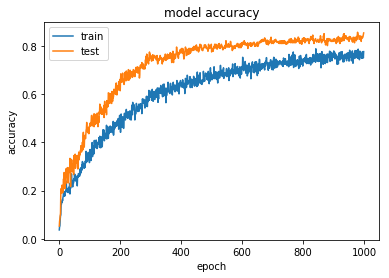

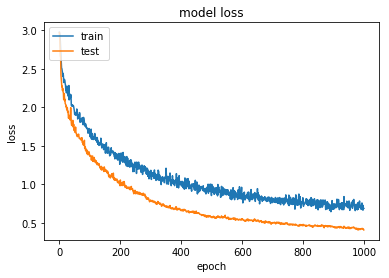

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction section

In [192]:
x_predict = np.zeros([0, timesteps, dimensions])
y_actual = np.zeros([0])

for word_no, word in enumerate(words):
    for data_no in range(3):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)

        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_predict = np.vstack((x_predict, [_timesteps]))
        y_actual = np.append(y_actual, word_no)
        
x_predict_norm = (x_predict-x_mean)/x_std
    
prediction = model.predict(x_predict_norm, verbose = 1)

57/57 [==============================] - 0s 527us/step


In [193]:
prediction_word_index = np.argmax(prediction, axis = 1)

prediction_words = np.zeros([0, 2])

for idx in prediction_word_index:
    prediction_words = np.vstack((prediction_words, [idx, words[idx]]))

In [194]:
print(prediction_words)

[['0' 'come quickly']
 ['0' 'come quickly']
 ['0' 'come quickly']
 ['1' 'emergency']
 ['1' 'emergency']
 ['1' 'emergency']
 ['2' 'father']
 ['2' 'father']
 ['2' 'father']
 ['3' 'fever']
 ['5' 'headache']
 ['5' 'headache']
 ['4' 'good luck']
 ['4' 'good luck']
 ['4' 'good luck']
 ['5' 'headache']
 ['5' 'headache']
 ['5' 'headache']
 ['6' 'hello']
 ['6' 'hello']
 ['6' 'hello']
 ['14' 'not ok']
 ['7' 'help']
 ['7' 'help']
 ['8' 'hi']
 ['8' 'hi']
 ['8' 'hi']
 ['9' 'hungry']
 ['9' 'hungry']
 ['9' 'hungry']
 ['10' 'like']
 ['10' 'like']
 ['9' 'hungry']
 ['11' 'mother']
 ['11' 'mother']
 ['11' 'mother']
 ['12' 'mother_father']
 ['12' 'mother_father']
 ['12' 'mother_father']
 ['13' 'mother_mother']
 ['13' 'mother_mother']
 ['13' 'mother_mother']
 ['14' 'not ok']
 ['14' 'not ok']
 ['14' 'not ok']
 ['15' 'quickly']
 ['10' 'like']
 ['15' 'quickly']
 ['16' 'sorry']
 ['16' 'sorry']
 ['16' 'sorry']
 ['17' 'tomorrow']
 ['17' 'tomorrow']
 ['17' 'tomorrow']
 ['18' 'yogurt']
 ['9' 'hungry']
 ['18' 'yogu